# Submission details

***
##    1st part (10 marks) - Sections 2 and 3
##    2nd part (2 marks) - Sections 4 and 5
##    3rd part (3 marks) - Sections 6 to 9
***

# Toronto's neighborhoods clustering

***
In this workbook i will build a dataset with information about Toronto's neighborhoods and apply a clustering algorithm to help visualize how can they compare with each other regarding the kind of venues available at those neighborhoods.

The dataset will be built with information from several sources:
> Neighborhoods, boroughs and postal codes -> https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

> Latitute and longitude -> geocoder package

> Venues -> FourSquare

***

## 1) Import section

In [110]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from bs4 import BeautifulSoup # library for web scrapping

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# transforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # geographic plotting library

from math import sin, cos, sqrt, atan2, radians

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

%matplotlib inline

print("Libraries import completed!")

Libraries import completed!


## 2) Web scrapping

I will start by retrieving data from a table in https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and create a dataframe with that data (*Postal code*, *Borough* and *Neighborhood*).

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
my_request = requests.get(wiki_url)

if my_request:
    print("Data retrieved from %s with success!" % wiki_url)
else:
    print("Failed to read from %s with error code %s" % (wiki_url, my_request.status_code))

Data retrieved from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M with success!


In [4]:
print(my_request.text)

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XleEwgpAMFQAAJC09fgAAAAK","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":942851379,"wgRevisionId":942851379,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario

First step: find the table within the html page (find the first table with class="wikitable sortable")

In [5]:
soup = BeautifulSoup(my_request.text, 'html.parser')

table_pointer = soup.find('table', {"class": "wikitable sortable"})

if table_pointer:
    print("Table read!")

Table read!


Second step: retrieve the first row of the table (header) and build a list to use as our dataframe columns

In [6]:
rows = table_pointer.find_all('tr')
header = rows[0]
table_columns = header.find_all('th')
table_columns = [column.get_text().replace('\n','').replace('Neighbourhood', 'Neighborhood') for column in table_columns]

print("The dataframe columns will be %s" % table_columns)

The dataframe columns will be ['Postcode', 'Borough', 'Neighborhood']


Third step: build three lists (one for each column) with the retrieved from each table row

In [7]:
postcode_list = []
borough_list = []
neighborhood_list = []
for row in rows[1:]:
    columns = row.find_all('td')
    postcode_list.extend([columns[0].get_text().replace('\n','').strip()])
    borough_list.extend([columns[1].get_text().replace('\n','').strip()])
    neighborhood_list.extend([columns[2].get_text().replace('\n','').strip()])
print("First 5 postal codes: %s" % postcode_list[0:5])
print("First 5 boroughs: %s" % borough_list[0:5])
print("First 5 neighborhoods: %s" % neighborhood_list[0:5])
print("Last 5 postal codes: %s" % postcode_list[-5:])
print("Last 5 boroughs: %s" % borough_list[-5:])
print("Last 5 neighborhoods: %s" % neighborhood_list[-5:])

First 5 postal codes: ['M1A', 'M2A', 'M3A', 'M4A', 'M5A']
First 5 boroughs: ['Not assigned', 'Not assigned', 'North York', 'North York', 'Downtown Toronto']
First 5 neighborhoods: ['Not assigned', 'Not assigned', 'Parkwoods', 'Victoria Village', 'Harbourfront']
Last 5 postal codes: ['M8Z', 'M8Z', 'M8Z', 'M8Z', 'M9Z']
Last 5 boroughs: ['Etobicoke', 'Etobicoke', 'Etobicoke', 'Etobicoke', 'Not assigned']
Last 5 neighborhoods: ['Mimico NW', 'The Queensway West', 'Royal York South West', 'South of Bloor', 'Not assigned']


Last step: convert all the retrieved info to a dataframe

In [8]:
toronto_neighborhoods = pd.DataFrame(list(zip(postcode_list, borough_list, neighborhood_list)), columns=table_columns)
toronto_neighborhoods.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## 3) Shaping the dataframe

In this section i will shape the dataframe to comply with the following requisites:

> Remove rows with **Borough** value 'Not assigned' (commented as 1st step)

> For rows with **Neighborhood** with value 'Not assigned' use the same value as **Borough** (commented as 2nd step)

> Combine neighborhoods with the same postal code into one row in which **Neighborhood** will have those neighborhoods comma separated (commented as 3rd step)

In [9]:
# 1st step
toronto_neighborhoods_processed = toronto_neighborhoods.replace('Not assigned', np.NAN)
toronto_neighborhoods_processed.dropna(axis=0, subset=['Borough'], inplace=True)
toronto_neighborhoods_processed.head(10)

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [10]:
# 2nd step
toronto_neighborhoods_processed.Neighborhood.fillna(toronto_neighborhoods_processed.Borough, inplace=True)
toronto_neighborhoods_processed.head(10)

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [11]:
# 3rd step
toronto_neighborhoods_processed = toronto_neighborhoods_processed.groupby(['Postcode','Borough'])['Neighborhood'].apply(lambda x: "%s" % ','.join(x)).reset_index()
toronto_neighborhoods_processed.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [12]:
print("Dataframe shape is (%s, %s)" % toronto_neighborhoods_processed.shape)

Dataframe shape is (103, 3)


## 4) Retrieving geodata

I tried to use geopy package to retrieve latitute and longitude information for each postal code, but unfortunately "Service not available" was the only response i got

In [13]:
#geolocator = Nominatim(user_agent='toronto_CA')

#address_list = [r['Postcode']+' '+r['Borough'] for i, r in toronto_neighborhoods_processed.iterrows()]
#lat_list = []
#long_list = []

#for address in address_list:
#    coordinates = None
#    while coordinates is None:
#        coordinates = geolocator.geocode(address)
#        
#    lat_list.extend([coordinates.latitude])
#    long_list.extend([coordinates.longitude])
    
#print("Coordinates retrieved: %s latitude records and %s longitude records" % (len(lat_list), len(long_list)))

In [14]:
coordinates = pd.read_csv('http://cocl.us/Geospatial_data')

print("Coordinates dataframe shape is (%s, %s)" % coordinates.shape)

coordinates.head()

Coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## 5) Build dataframe with coordinates

I will now join the current dataframe (*toronto_neighborhoods_processed*) with the coordinates dataframe (*coordinates*)

In [15]:
coordinates.columns = ['Postcode']+list(coordinates.columns[1:])
print("Coordinates dataframe columns: %s" % list(coordinates.columns))

toronto_neighborhoods_with_geo = toronto_neighborhoods_processed.join(coordinates.set_index('Postcode'), on='Postcode')
print("New dataframe shape is (%s, %s)" % toronto_neighborhoods_with_geo.shape)
toronto_neighborhoods_with_geo.columns = ['PostalCode']+list(toronto_neighborhoods_with_geo.columns[1:])

toronto_neighborhoods_with_geo.head(12)

Coordinates dataframe columns: ['Postcode', 'Latitude', 'Longitude']
New dataframe shape is (103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


## 6) Visualy explore the dataframe

I will now plot the neighborhoods on Toronto's map

In [16]:
toronto_coordinates = [43.727, -79.37]
toronto_map = folium.Map(location=toronto_coordinates, zoom_start=11)

for lat, lng, label in zip(toronto_neighborhoods_with_geo['Latitude'], toronto_neighborhoods_with_geo['Longitude'], toronto_neighborhoods_with_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  

toronto_map

As we can see neighborhoods are more concentrated in Toronto's downtown and more sparse on Toronto's borders. When exploring for venues, if we choose a small radius there's a risk that we miss venues in sparse areas but if we pick a larger radius there's the risk of venues overlap on more dense areas.

I will assume that the coordinates i have, represent the center of each postal code. I will then build a matrix of distances between each postal code, for each postal code i will pick the distance to the closest postal code and finally divide that distance by two (since it's fair to assume that the border between postal codes is at the middle of the distance). This will be the radius when exploring venues (smaller for dense areas, larger for sparse areas).

## 7) Define neighborhood radius

In [17]:
def get_distance(A, B):
    """This function returns the distance in meters between two points a and b (haversine formula)
    
        Arguments:
        ----------
            A : tuple
                a pair of latitude, longitude coordinates (in degrees)
            B : tuple
                a pair of latitude, longitude coordinates (in degrees)"""
    R = 6373000 #aprox Earth radius in meters
    latA = radians(A[0])
    longA = radians(A[1])
    latB = radians(B[0])
    longB = radians(B[1])

    delta_long = longB - longA
    delta_lat = latB - latA

    a = sin(delta_lat / 2)**2 + cos(latA) * cos(latB) * sin(delta_long / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

print("Function get_distance created!")

Function get_distance created!


In [18]:
# Build empty distance matrix between postal codes as a dataframe

num_points = toronto_neighborhoods_with_geo.shape[0]
empty_matrix = np.zeros((num_points, num_points))

distance_matrix = pd.DataFrame(empty_matrix, index=toronto_neighborhoods_with_geo['PostalCode'], columns=toronto_neighborhoods_with_geo['PostalCode'])
distance_matrix.head()


PostalCode,M1B,M1C,M1E,M1G,M1H,M1J,M1K,M1L,M1M,M1N,...,M9A,M9B,M9C,M9L,M9M,M9N,M9P,M9R,M9V,M9W
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Build an auxiliary dictionary to translate postal codes in coordenates

postal_code_coordinates = {}
for i, row in toronto_neighborhoods_with_geo.iterrows():
    postal_code_coordinates[row['PostalCode']] = (row['Latitude'], row['Longitude'])
    
postal_code_coordinates

{'M1B': (43.806686299999996, -79.19435340000001),
 'M1C': (43.7845351, -79.16049709999999),
 'M1E': (43.7635726, -79.1887115),
 'M1G': (43.7709921, -79.21691740000001),
 'M1H': (43.773136, -79.23947609999999),
 'M1J': (43.7447342, -79.23947609999999),
 'M1K': (43.7279292, -79.26202940000002),
 'M1L': (43.711111700000004, -79.2845772),
 'M1M': (43.716316, -79.23947609999999),
 'M1N': (43.692657000000004, -79.2648481),
 'M1P': (43.7574096, -79.27330400000001),
 'M1R': (43.750071500000004, -79.2958491),
 'M1S': (43.7942003, -79.26202940000002),
 'M1T': (43.7816375, -79.3043021),
 'M1V': (43.8152522, -79.2845772),
 'M1W': (43.799525200000005, -79.3183887),
 'M1X': (43.836124700000006, -79.20563609999999),
 'M2H': (43.8037622, -79.3634517),
 'M2J': (43.7785175, -79.3465557),
 'M2K': (43.7869473, -79.385975),
 'M2L': (43.7574902, -79.37471409999999),
 'M2M': (43.789053, -79.40849279999999),
 'M2N': (43.7701199, -79.40849279999999),
 'M2P': (43.752758299999996, -79.4000493),
 'M2R': (43.78273

In [20]:
# Calculate distances

for col in distance_matrix.columns:
    for idx in distance_matrix.index:
        if col != idx:
            if distance_matrix.at[idx, col] == 0:
                distance = get_distance(postal_code_coordinates[idx], postal_code_coordinates[col])
                distance_matrix.at[idx, col] = distance
                distance_matrix.at[col, idx] = distance

distance_matrix.replace(0, np.nan, inplace=True)
distance_matrix.head()

PostalCode,M1B,M1C,M1E,M1G,M1H,M1J,M1K,M1L,M1M,M1N,...,M9A,M9B,M9C,M9L,M9M,M9N,M9P,M9R,M9V,M9W
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,NaN,3668.709708,4816.882857,4364.126536,5201.276779,7785.758065,10309.755663,12866.624677,10685.486454,13890.749711,...,31238.278316,33750.441036,35727.270346,30364.158546,28630.395536,28286.359220,29794.707640,31781.991495,32524.146463,33981.293171
M1C,3668.709708,NaN,3251.414392,4775.015947,6468.266816,7736.194683,10304.434811,12887.928291,9891.754055,13219.888845,...,32577.719333,35003.140745,36991.777456,32718.462315,30597.762520,30011.925185,31444.073534,33420.435964,34741.748379,35896.465526
M1E,4816.882857,3251.414392,NaN,2411.268904,4214.070587,4585.348463,7101.173607,9664.666040,6653.705614,9983.489231,...,29598.994312,31985.006272,33973.267589,30317.311603,27940.269606,27220.066501,28606.785521,30569.999372,32228.669243,33184.194718
M1G,4364.126536,4775.015947,2411.268904,NaN,1827.512706,3437.260717,6006.785146,8597.959161,6346.028478,9526.817859,...,27823.803059,30264.900509,32252.805920,28086.432401,25853.203551,25239.606562,26669.142847,28645.422349,30054.305547,31138.972599
M1H,5201.276779,6468.266816,4214.070587,1827.512706,NaN,3159.127477,5344.902155,7793.005843,6320.079124,9180.990305,...,26287.299966,28759.945917,30744.700423,26293.008888,24131.128623,23579.237457,25032.647208,27014.383447,28285.256675,29435.830386


In [21]:
# Build a dictionary with the maximum radius from each postal code without overlaping a neighbour's postal code

distance_matrix['Radius'] = distance_matrix.min(axis=1)
postal_code_radius = {}

for idx in distance_matrix.index:
    postal_code_radius[idx] = distance_matrix.at[idx,'Radius']/2
    
postal_code_radius

{'M1B': 1698.6573717358262,
 'M1C': 1625.7071960265678,
 'M1E': 1205.634452066322,
 'M1G': 913.7563530828431,
 'M1H': 913.7563530828431,
 'M1J': 1301.8505732622175,
 'M1K': 1113.0389518773975,
 'M1L': 1052.6876577790244,
 'M1M': 1113.0389518773975,
 'M1N': 1297.163935729433,
 'M1P': 993.3776748243724,
 'M1R': 993.3776748243724,
 'M1S': 1479.8031835226504,
 'M1T': 1144.334569741731,
 'M1V': 1479.8031835226504,
 'M1W': 1144.334569741731,
 'M1X': 1698.6573717358262,
 'M2H': 1300.7866607015224,
 'M2J': 1559.2558150875166,
 'M2K': 911.6136204154154,
 'M2L': 1051.2083470454627,
 'M2M': 911.6136204154154,
 'M2N': 1023.3932774860907,
 'M2P': 1023.3932774860907,
 'M2R': 1400.5034707979912,
 'M3A': 993.2732302890845,
 'M3B': 993.2732302890845,
 'M3C': 1018.8831227197956,
 'M3H': 1302.3758120103903,
 'M3J': 1400.2921561927483,
 'M3K': 1054.1918674173985,
 'M3L': 739.208414372957,
 'M3M': 739.208414372957,
 'M3N': 1378.7627683883916,
 'M4A': 1018.8831227197956,
 'M4B': 702.401512645275,
 'M4C': 70

In [22]:
# Map with a fixed radius of 500m for each postal code

toronto_coordinates = [43.727, -79.37]
toronto_map_fixed_radius = folium.Map(location=toronto_coordinates, zoom_start=11)

for lat, lng, label in zip(toronto_neighborhoods_with_geo['Latitude'], toronto_neighborhoods_with_geo['Longitude'], toronto_neighborhoods_with_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map_fixed_radius)  

toronto_map_fixed_radius

As expected a fixed radius of 500m implies some neighborhood overlaps in Toronto's dowtown and it lacks coverage on peripheral neighborhoods.

In [23]:
# Map with a dynamic radius for each postal code (minimum distance before overlaping nearest neighbour)

toronto_coordinates = [43.727, -79.37]
toronto_map_dynamic_radius = folium.Map(location=toronto_coordinates, zoom_start=11)

for lat, lng, label, pcode in zip(toronto_neighborhoods_with_geo['Latitude'], toronto_neighborhoods_with_geo['Longitude'], 
                           toronto_neighborhoods_with_geo['Neighborhood'], toronto_neighborhoods_with_geo['PostalCode']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=postal_code_radius[pcode],
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map_dynamic_radius)  

toronto_map_dynamic_radius

With a dynamic radius, as expected, there's a higher coverage of the city, but downtown's neighborhoods have now a very small radius and that can lead to a wrong evaluation of those neighborhoods.

I will now use these radius to obtain the venues around each neighborhood. Depending on the results i will decide if i keep them, if i opt for the fixed 500m radius or if i define another radius strategy.

# 8) Retrieve neighborhood's venues

I will use *FourSquare.com* to obtain the venues with the radius defined on **toronto_map_dynamic_radius** and limited to 100 venues per neighborhood.

In [24]:
CLIENT_ID = 'QOQNP5QLBCEEANEZIMHWICVBJ3JWGWSSTZHSWLW1BOYDIYUU' # my Foursquare ID
CLIENT_SECRET = 'G5KKOAD0ETLQMBN4P1EWID4EA1R3KWSMTEB552TV1W00PE4H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

credentials = 'client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
base_url = 'https://api.foursquare.com/v2/venues/'
endpoint = 'explore?'

In [30]:
venues_list=[]
p_codes = toronto_neighborhoods_with_geo['PostalCode']
boroughs = toronto_neighborhoods_with_geo['Borough']
neighborhoods = toronto_neighborhoods_with_geo['Neighborhood']
latitudes = toronto_neighborhoods_with_geo['Latitude']
longitudes = toronto_neighborhoods_with_geo['Longitude']
for p_code, borough, neighborhood, lat, lng in zip(p_codes, boroughs, neighborhoods, latitudes, longitudes):
            
    # create the API request URL
    api_params = 'll='+str(lat)+','+str(lng)+'&radius='+str(int(postal_code_radius[p_code]))+'&limit=100'
    url = base_url+endpoint+credentials+'&'+api_params
            
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    # return only relevant information for each nearby venue
    venues_list.append([(
        p_code,
        borough,
        neighborhood,
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['PostalCode',
                         'Borough',
                         'Neighborhood',
                         'Latitude',
                         'Longitude',
                         'Venue',
                         'VenueLatitude',
                         'VenueLongitude',
                         'VenueCategory']

I will now try to evaluate if the usage of a dynamic radius has a negative impact on the venue retrieval.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f530271dad0>]],
      dtype=object)

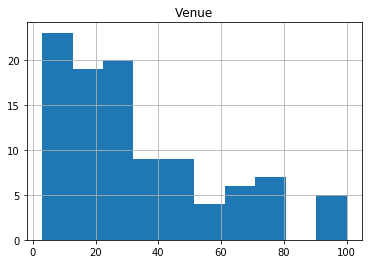

In [55]:
venues_by_postal_code = nearby_venues.groupby(['PostalCode']).count()

venues_by_postal_code.hist(column=['Venue'])

We can see that most of the neighborhoods have less than 40 venues. I will now compare the number of venues retireved with the used radius.

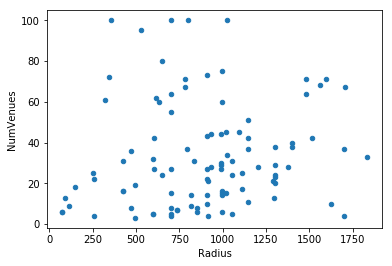

In [62]:
c1 = venues_by_postal_code.index
c2 = venues_by_postal_code['Venue']
c3 = [postal_code_radius[pcode] for pcode in c1 ]

radius_analysis = pd.DataFrame({'NumVenues': c2, 'Radius': c3}, index=c1)
radius_analysis.plot.scatter(x='Radius', y='NumVenues')

We can see the some neighborhoods with smallest radius have less than 20 venues. Let's see which neighborhoods are we talking about.

In [63]:
radius_analysis[radius_analysis['Radius']<250]

,NumVenues,Radius
PostalCode,,
M5H,18,150.543987
M5K,6,75.190435
M5L,13,90.787546
M5W,9,111.388542
M5X,6,75.190435


There's also the chance that some neighborhoods got no venues due to the small radius. Let's verify that.

In [64]:
set(toronto_neighborhoods_with_geo['PostalCode']) - set(nearby_venues['PostalCode'])

{'M5E'}

In [65]:
postal_code_radius['M5E']

111.3885417384955

Looking at the results we can see that 6 neighborhoods will be hard classify due to the small radius used. So i will define a miminum radius of 300m for the actual radius dictionary.

In [67]:
for pcode in postal_code_radius.keys():
    postal_code_radius[pcode] = max(300, postal_code_radius[pcode])

Now let's retrieve the venues with the new radius.

In [70]:
venues_list=[]
p_codes = toronto_neighborhoods_with_geo['PostalCode']
boroughs = toronto_neighborhoods_with_geo['Borough']
neighborhoods = toronto_neighborhoods_with_geo['Neighborhood']
latitudes = toronto_neighborhoods_with_geo['Latitude']
longitudes = toronto_neighborhoods_with_geo['Longitude']
for p_code, borough, neighborhood, lat, lng in zip(p_codes, boroughs, neighborhoods, latitudes, longitudes):
            
    # create the API request URL
    api_params = 'll='+str(lat)+','+str(lng)+'&radius='+str(int(postal_code_radius[p_code]))+'&limit=100'
    url = base_url+endpoint+credentials+'&'+api_params
            
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    # return only relevant information for each nearby venue
    venues_list.append([(
        p_code,
        borough,
        neighborhood,
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['PostalCode',
                         'Borough',
                         'Neighborhood',
                         'Latitude',
                         'Longitude',
                         'Venue',
                         'VenueLatitude',
                         'VenueLongitude',
                         'VenueCategory']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5302af3810>]],
      dtype=object)

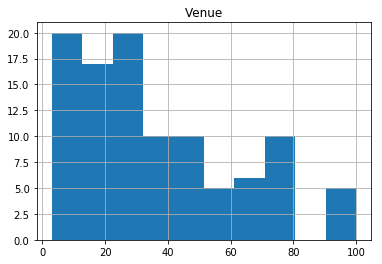

In [71]:
venues_by_postal_code = nearby_venues.groupby(['PostalCode']).count()

venues_by_postal_code.hist(column=['Venue'])

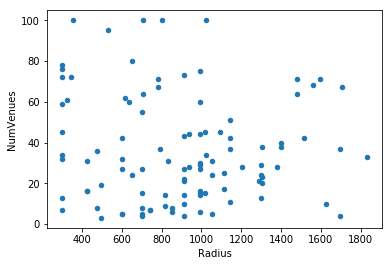

In [72]:
c1 = venues_by_postal_code.index
c2 = venues_by_postal_code['Venue']
c3 = [postal_code_radius[pcode] for pcode in c1 ]

radius_analysis = pd.DataFrame({'NumVenues': c2, 'Radius': c3}, index=c1)
radius_analysis.plot.scatter(x='Radius', y='NumVenues')

In [74]:
set(toronto_neighborhoods_with_geo['PostalCode']) - set(nearby_venues['PostalCode'])

set()

Now we have more balanced results. Next step is to one-hot encode the venue categories.

In [85]:
nearby_venues.groupby(['PostalCode']).count()

,Borough,Neighborhood,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,,,,,,,,
M1B,37,37,37,37,37,37,37,37
M1C,10,10,10,10,10,10,10,10
M1E,28,28,28,28,28,28,28,28
M1G,4,4,4,4,4,4,4,4
M1H,21,21,21,21,21,21,21,21
M1J,24,24,24,24,24,24,24,24
M1K,25,25,25,25,25,25,25,25
M1L,31,31,31,31,31,31,31,31
M1M,17,17,17,17,17,17,17,17


In [99]:
# one hot encoding
toronto_onehot = pd.get_dummies(nearby_venues[['VenueCategory']], prefix="", prefix_sep="")

# add PostalCode column to dataframe
toronto_onehot['PostalCode'] = nearby_venues['PostalCode']

# move PostalCode column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
fixed_columns
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


And let's examine the new dataframe size.

In [100]:
toronto_onehot.shape

(3698, 332)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [101]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,M1B,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.027027,0.000000,0.540541
1,M1C,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,M1E,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,M1G,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,M1H,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.047619,0.000000
5,M1J,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,M1K,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.040000,0.000000,0.000000,0.000000
7,M1L,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,M1M,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,M1N,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


Let's confirm the new size.

In [102]:
toronto_grouped.shape

(103, 332)

Let's print each neighborhood along with the top 5 most common venues.

In [103]:
num_top_venues = 5

for hood in toronto_grouped['PostalCode']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                  venue  freq
0           Zoo Exhibit  0.54
1           Pizza Place  0.05
2  Fast Food Restaurant  0.05
3      Greek Restaurant  0.03
4            Restaurant  0.03


----M1C----
           venue  freq
0          Hotel   0.1
1       Pharmacy   0.1
2   Neighborhood   0.1
3  Grocery Store   0.1
4            Gym   0.1


----M1E----
                  venue  freq
0           Pizza Place  0.14
1           Coffee Shop  0.07
2  Fast Food Restaurant  0.07
3   Fried Chicken Joint  0.04
4          Burger Joint  0.04


----M1G----
               venue  freq
0               Park   0.5
1        Coffee Shop   0.5
2  Accessories Store   0.0
3             Museum   0.0
4       Noodle House   0.0


----M1H----
               venue  freq
0             Bakery  0.14
1  Indian Restaurant  0.10
2        Coffee Shop  0.10
3        Music Store  0.05
4  German Restaurant  0.05


----M1J----
            venue  freq
0  Sandwich Place  0.17
1        Pharmacy  0.12
2   Grocery Store  0.08


                venue  freq
0         Pizza Place  0.08
1        Dessert Shop  0.08
2  Italian Restaurant  0.06
3                 Gym  0.06
4    Sushi Restaurant  0.06


----M4T----
               venue  freq
0               Park   0.4
1         Playground   0.2
2       Tennis Court   0.2
3                Gym   0.2
4  Accessories Store   0.0


----M4V----
                venue  freq
0         Coffee Shop  0.13
1  Italian Restaurant  0.07
2          Restaurant  0.05
3    Sushi Restaurant  0.05
4            Pharmacy  0.04


----M4W----
               venue  freq
0               Park   0.6
1              Trail   0.2
2         Playground   0.2
3  Accessories Store   0.0
4             Museum   0.0


----M4X----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.05
2         Pizza Place  0.05
3              Bakery  0.03
4  Italian Restaurant  0.03


----M4Y----
              venue  freq
0           Gay Bar  0.08
1       Coffee Shop  0.07
2      Burger Joint  0.0

         venue  freq
0         Park  0.19
1        Hotel  0.12
2  Pizza Place  0.12
3         Bank  0.06
4         Café  0.06


----M9C----
                venue  freq
0         Coffee Shop  0.13
1      Cosmetics Shop  0.07
2  College Rec Center  0.07
3       Shopping Mall  0.07
4         Gas Station  0.07


----M9L----
                   venue  freq
0      Electronics Store  0.15
1                   Park  0.10
2  General Entertainment  0.05
3                   Bank  0.05
4                 Bakery  0.05


----M9M----
               venue  freq
0        Golf Course  0.18
1             Bakery  0.09
2               Park  0.09
3   Storage Facility  0.09
4  Convenience Store  0.09


----M9N----
                 venue  freq
0                 Park  0.22
1    Convenience Store  0.11
2       Breakfast Spot  0.11
3                 Café  0.11
4  Fried Chicken Joint  0.11


----M9P----
                       venue  freq
0                Pizza Place  0.14
1         Chinese Restaurant  0.07
2        

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [104]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Zoo Exhibit,Pizza Place,Fast Food Restaurant,Gas Station,Other Great Outdoors,Liquor Store,Restaurant,Greek Restaurant,Paper / Office Supplies Store,Coffee Shop
1,M1C,Breakfast Spot,Neighborhood,Burger Joint,Hotel,Pharmacy,Gym / Fitness Center,Gym,Grocery Store,Park,Italian Restaurant
2,M1E,Pizza Place,Coffee Shop,Fast Food Restaurant,Park,Pharmacy,Restaurant,Discount Store,Sandwich Place,Burger Joint,Automotive Shop
3,M1G,Coffee Shop,Park,Zoo Exhibit,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Bakery,Coffee Shop,Indian Restaurant,Pizza Place,Music Store,Fried Chicken Joint,Caribbean Restaurant,Gas Station,Bank,Thai Restaurant


## 9) Cluster neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [105]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 3, 2, 0, 2, 2, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [106]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

toronto_merged = toronto_neighborhoods_with_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Zoo Exhibit,Pizza Place,Fast Food Restaurant,Gas Station,Other Great Outdoors,Liquor Store,Restaurant,Greek Restaurant,Paper / Office Supplies Store,Coffee Shop
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1,Breakfast Spot,Neighborhood,Burger Joint,Hotel,Pharmacy,Gym / Fitness Center,Gym,Grocery Store,Park,Italian Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Pizza Place,Coffee Shop,Fast Food Restaurant,Park,Pharmacy,Restaurant,Discount Store,Sandwich Place,Burger Joint,Automotive Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Park,Zoo Exhibit,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2,Bakery,Coffee Shop,Indian Restaurant,Pizza Place,Music Store,Fried Chicken Joint,Caribbean Restaurant,Gas Station,Bank,Thai Restaurant


Finally, let's visualize the resulting clusters

In [111]:
# create map
map_clusters = folium.Map(location=toronto_coordinates, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi1, poi2, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                         toronto_merged['PostalCode'], toronto_merged['Neighborhood'], 
                                         toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi1) + '-' + str(poi2) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

### Cluster 1

In [117]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 0, toronto_merged.columns[[0,1,2] + list(range(6, toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",Zoo Exhibit,Pizza Place,Fast Food Restaurant,Gas Station,Other Great Outdoors,Liquor Store,Restaurant,Greek Restaurant,Paper / Office Supplies Store,Coffee Shop
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",Pizza Place,Coffee Shop,Fast Food Restaurant,Park,Pharmacy,Restaurant,Discount Store,Sandwich Place,Burger Joint,Automotive Shop
5,M1J,Scarborough,Scarborough Village,Sandwich Place,Pharmacy,Breakfast Spot,Grocery Store,Ice Cream Shop,Japanese Restaurant,Coffee Shop,Bus Station,Fast Food Restaurant,Fish & Chips Shop
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",Pizza Place,Harbor / Marina,Ice Cream Shop,Beach,Sandwich Place,Hardware Store,Sports Bar,Burger Joint,Cajun / Creole Restaurant,Park
11,M1R,Scarborough,"Maryvale,Wexford",Middle Eastern Restaurant,Pizza Place,Burger Joint,Grocery Store,Korean Restaurant,Gas Station,Badminton Court,Restaurant,Smoke Shop,Bar
15,M1W,Scarborough,L'Amoreaux West,Chinese Restaurant,Pizza Place,Coffee Shop,Fast Food Restaurant,Pharmacy,Bakery,Other Great Outdoors,Daycare,Park,Intersection
33,M3N,North York,Downsview Northwest,Pizza Place,Hotel,Fast Food Restaurant,Discount Store,Tennis Stadium,Gas Station,Coffee Shop,Theater,Vietnamese Restaurant,Pharmacy
35,M4B,East York,"Woodbine Gardens,Parkview Hill",Pizza Place,Intersection,Pharmacy,Restaurant,Rock Climbing Spot,Café,Bus Line,Fast Food Restaurant,Brewery,Bank
42,M4L,East Toronto,"The Beaches West,India Bazaar",Sandwich Place,Pizza Place,Ice Cream Shop,Steakhouse,Fish & Chips Shop,Burrito Place,Liquor Store,Sushi Restaurant,Movie Theater,Italian Restaurant
56,M5E,Downtown Toronto,Berczy Park,Concert Hall,Liquor Store,Breakfast Spot,Italian Restaurant,Restaurant,Beer Bar,Pub,Fast Food Restaurant,Electronics Store,Financial or Legal Service


### Cluster 2

In [119]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 1, toronto_merged.columns[[0,1,2] + list(range(6, toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",Breakfast Spot,Neighborhood,Burger Joint,Hotel,Pharmacy,Gym / Fitness Center,Gym,Grocery Store,Park,Italian Restaurant
9,M1N,Scarborough,"Birch Cliff,Cliffside West",Diner,Park,Skating Rink,Café,Bus Stop,Chinese Restaurant,Ice Cream Shop,Gym,Gym Pool,General Entertainment
17,M2H,North York,Hillcrest Village,Pharmacy,Park,Sandwich Place,Bank,Chinese Restaurant,Coffee Shop,Cantonese Restaurant,Bakery,Korean Restaurant,Campground
19,M2K,North York,Bayview Village,Gas Station,Grocery Store,Bank,Japanese Restaurant,Chinese Restaurant,Café,Intersection,Shopping Mall,Restaurant,Park
25,M3A,North York,Parkwoods,Park,Shopping Mall,Convenience Store,Pharmacy,Bus Stop,Fast Food Restaurant,Tennis Court,Food & Drink Shop,Caribbean Restaurant,Laundry Service
31,M3L,North York,Downsview West,Grocery Store,Pizza Place,Bank,Shopping Mall,Vietnamese Restaurant,Moving Target,Park,Electronics Store,Dog Run,Doner Restaurant
32,M3M,North York,Downsview Central,Business Service,Middle Eastern Restaurant,Photography Lab,Vietnamese Restaurant,Baseball Field,Outdoor Supply Store,Zoo Exhibit,Electronics Store,Dog Run,Doner Restaurant
36,M4C,East York,Woodbine Heights,Diner,Pharmacy,Skating Rink,Bus Line,Curling Ice,Park,Beer Store,Cosmetics Shop,Farmers Market,Farm
45,M4P,Central Toronto,Davisville North,Breakfast Spot,Hotel,Department Store,Park,Food & Drink Shop,Gym,Dog Run,Convenience Store,Empanada Restaurant,Doner Restaurant
64,M5P,Central Toronto,"Forest Hill North,Forest Hill West",Jewelry Store,Trail,Sushi Restaurant,Park,Empanada Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


### Cluster 3

In [120]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 2, toronto_merged.columns[[0,1,2] + list(range(6, toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M1H,Scarborough,Cedarbrae,Bakery,Coffee Shop,Indian Restaurant,Pizza Place,Music Store,Fried Chicken Joint,Caribbean Restaurant,Gas Station,Bank,Thai Restaurant
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",Coffee Shop,Fast Food Restaurant,Grocery Store,Discount Store,Chinese Restaurant,Burger Joint,Bus Line,Bus Station,Sandwich Place,Bank
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",Diner,Bus Line,Intersection,Coffee Shop,Bakery,Pharmacy,Gas Station,Restaurant,Bank,Beer Store
10,M1P,Scarborough,"Dorset Park,Scarborough Town Centre,Wexford He...",Coffee Shop,Electronics Store,Chinese Restaurant,Light Rail Station,Bakery,Furniture / Home Store,Restaurant,Indian Restaurant,Pharmacy,Fast Food Restaurant
12,M1S,Scarborough,Agincourt,Chinese Restaurant,Cantonese Restaurant,Hong Kong Restaurant,Bakery,Park,Coffee Shop,Caribbean Restaurant,Shopping Mall,Breakfast Spot,Pizza Place
13,M1T,Scarborough,"Clarks Corners,Sullivan,Tam O'Shanter",Park,Fast Food Restaurant,Coffee Shop,Intersection,Sandwich Place,Vietnamese Restaurant,Pizza Place,Pharmacy,Convenience Store,Seafood Restaurant
14,M1V,Scarborough,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Chinese Restaurant,Dessert Shop,Pharmacy,Coffee Shop,Bakery,Korean Restaurant,BBQ Joint,Bubble Tea Shop,Vietnamese Restaurant,Dumpling Restaurant
18,M2J,North York,"Fairview,Henry Farm,Oriole",Coffee Shop,Clothing Store,Middle Eastern Restaurant,Park,Japanese Restaurant,Chinese Restaurant,Gas Station,Juice Bar,Intersection,Fast Food Restaurant
21,M2M,North York,"Newtonbrook,Willowdale",Korean Restaurant,Pizza Place,Middle Eastern Restaurant,Café,Coffee Shop,Supermarket,Bank,Bakery,Diner,Dessert Shop
22,M2N,North York,Willowdale South,Ramen Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Korean Restaurant,Bubble Tea Shop,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Café


### Cluster 4

In [121]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 3, toronto_merged.columns[[0,1,2] + list(range(6, toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,M1G,Scarborough,Woburn,Coffee Shop,Park,Zoo Exhibit,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
20,M2L,North York,"Silver Hills,York Mills",Park,Pool,Coffee Shop,Empanada Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
48,M4T,Central Toronto,"Moore Park,Summerhill East",Park,Gym,Playground,Tennis Court,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
50,M4W,Downtown Toronto,Rosedale,Park,Trail,Playground,Empanada Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


### Cluster 5

In [122]:
toronto_merged.loc[toronto_merged['ClusterLabels'] == 4, toronto_merged.columns[[0,1,2] + list(range(6, toronto_merged.shape[1]))]]

,PostalCode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,M1X,Scarborough,Upper Rouge,Playground,Trail,Farm,Sculpture Garden,Zoo Exhibit,Eastern European Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
73,M6C,York,Humewood-Cedarvale,Hockey Arena,Trail,Playground,Field,Farmers Market,Electronics Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
